In [10]:
import os
import glob
import sys

import numpy as np
import xarray
import xrspatial.multispectral as ms
from PIL import Image
import cv2
import tqdm
import skimage
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, ReLU, Concatenate, Activation, Input, Dropout, BatchNormalization, Add
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.legacy import Adam



In [19]:
IMAGE_HEIGHT, IMAGE_WIDTH = skimage.io.imread('data/train/imgs/adwp.jpg').shape
print('shape: ', (IMAGE_HEIGHT, IMAGE_WIDTH))
BATCH_SIZE = 16
EPOCHS = 30
train_imgs_dir, train_labels_dir = 'data/train/imgs', 'data/train/labels'
valid_imgs_dir, valid_labels_dir = 'data/valid/imgs', 'data/valid/labels'
test_imgs_dir, test_labels_dir = 'data/test/imgs', 'data/test/labels'

shape:  (512, 512)


In [20]:
len(os.listdir(train_imgs_dir))

11748

## Data Preprocessing

In [21]:
def read_image(filename):
    return skimage.io.imread(filename)

def random_augmentation(image, mask):
    # Random horizontal flip
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)

    # Random vertical flip
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 0)
        mask = cv2.flip(mask, 0)

    # Random rotation
    angle = np.random.randint(-45, 45)
    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    image = cv2.warpAffine(image, rotation_matrix, (width, height), borderMode=cv2.BORDER_REFLECT)
    mask = cv2.warpAffine(mask, rotation_matrix, (width, height), borderMode=cv2.BORDER_REFLECT)

    # Random shear
    shear_factor = np.random.uniform(-0.2, 0.2)
    shear_matrix = np.array([[1, shear_factor, 0],
                            [0, 1, 0]], dtype=np.float32)
    image = cv2.warpAffine(image, shear_matrix, (width, height), borderMode=cv2.BORDER_REFLECT)
    mask = cv2.warpAffine(mask, shear_matrix, (width, height), borderMode=cv2.BORDER_REFLECT)

    # Random zoom
    zoom_factor = np.random.uniform(0.8, 1.2)
    zoom_matrix = np.array([[zoom_factor, 0, 0],
                            [0, zoom_factor, 0]], dtype=np.float32)
    image = cv2.warpAffine(image, zoom_matrix, (width, height), borderMode=cv2.BORDER_REFLECT)
    mask = cv2.warpAffine(mask, zoom_matrix, (width, height), borderMode=cv2.BORDER_REFLECT)

    return image, mask  

def get_img_and_mask_data(img_dir, mask_dir, desired_shape=[None], num_imgs=None):
    if not num_imgs:
        num_imgs = len(glob.glob(img_dir.rstrip('/') + '/*'))
    if len(desired_shape) > 0:
        X = np.empty((num_imgs, desired_shape[0], desired_shape[1]))
        y = np.empty_like(X)
    else:
        X = np.empty((num_imgs, IMAGE_HEIGHT, IMAGE_WIDTH))
        y = np.empty_like(X)
    print('loading in images ...')
    permutation = np.arange(len(X))
    np.random.shuffle(permutation)
    i = 0
    for img_file in tqdm.tqdm(glob.glob(img_dir.rstrip('/') + '/*')[:num_imgs]):
        name = img_file.split('/')[-1]
        img = skimage.io.imread(img_file).astype(np.float32) / 255.
        mask = skimage.io.imread(os.path.join(mask_dir, name)).astype(np.float32)
        if len(desired_shape) > 0:
            img = img[:desired_shape[0], :desired_shape[1]]
            mask = mask[:desired_shape[0], :desired_shape[1]]
        img, mask = random_augmentation(img, mask)
        X[permutation[i]] = img
        y[permutation[i]] = (mask > 0).astype(np.float32)
        i += 1
    print('found {} image, mask pairs!'.format(len(X)))
    return X, y



In [22]:
desired_shape = (256, 256)
train_X, train_y = get_img_and_mask_data(train_imgs_dir, train_labels_dir, desired_shape, num_imgs=5120)
valid_X, valid_y = get_img_and_mask_data(valid_imgs_dir, valid_labels_dir, desired_shape, num_imgs=512)
IMAGE_HEIGHT, IMAGE_WIDTH = desired_shape[0], desired_shape[1]

loading in images ...


  0%|          | 0/5120 [00:00<?, ?it/s]

100%|██████████| 5120/5120 [00:17<00:00, 290.79it/s]


found 5120 image, mask pairs!
loading in images ...


100%|██████████| 512/512 [00:01<00:00, 313.84it/s]

found 512 image, mask pairs!


## Visualize Data

[2513 5110 4897]


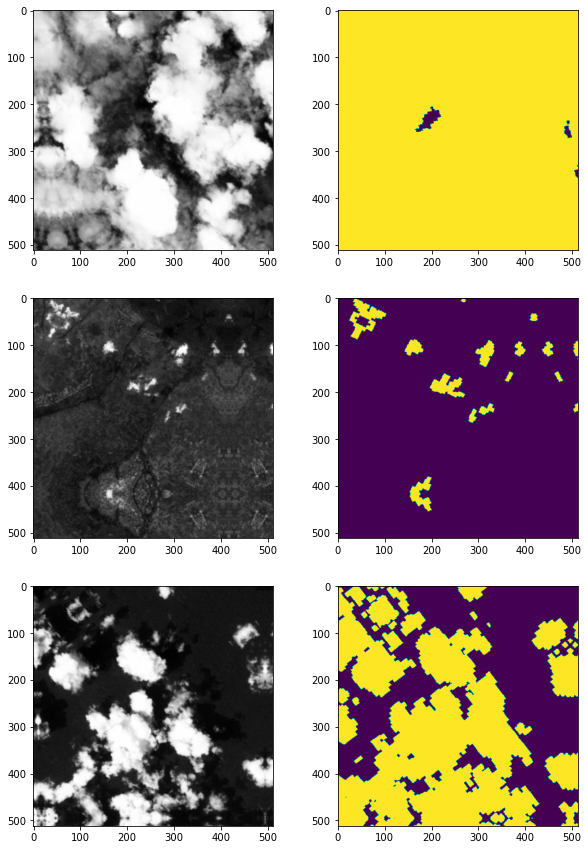

In [110]:
idx = np.random.choice(np.arange(len(train_X)), 3)
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
print(idx)
i = 0
for (ax1, ax2) in axes:
    ax1.imshow(train_X[idx[i]], 'gray')
    ax2.imshow(train_y[idx[i]])
    i += 1
plt.show()

## Model Architecture

In [47]:
def convolution_block(input, num_filters, res=False):
    x = Conv2D(num_filters, 3, padding='same')(input)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    if res:
        skip = Conv2D(num_filters, 1, padding='same')(input)
        new_x = Add()([x, skip])
        x = ReLU()(new_x)
    else:
        x = ReLU()(x)
    return x

def down(input, num_filters, res=False):
    x = convolution_block(input, num_filters, res)
    out = MaxPooling2D(2, 2)(x)
    return x, out

# def resblock(orig_input, input, num_filters):
#     x = convolution_block(input, num_filters)
#     x = Conv2D(num_filters)(x)


def up(input, concat, num_filters, res=False):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(input)
    x = Concatenate()([x, concat])
    x = convolution_block(x, num_filters, res)
    return x

def unet(shape, res=False):
    inputs = Input(shape)

    features_1, pool_1 = down(inputs, 8, res)
    features_2, pool_2 = down(pool_1, 16, res)
    features_3, pool_3 = down(pool_2, 32, res)
    #features_4, pool_4 = down(pool_3, 64)

    bottom = convolution_block(pool_3, 64, res)
    drop = Dropout(0.5)(bottom)

    #up_1 = up(drop, features_4, 64)
    up_2 = up(drop, features_3, 32, res)
    up_3 = up(up_2, features_2, 16, res)
    up_4 = up(up_3, features_1, 8, res)

    out = Conv2D(1, 1, padding='same', activation='sigmoid')(up_4)

    model = Model(inputs, out, name='unet')
    return model


## Loss Function

In [48]:
def dice_coefficient(y_true, y_pred, smooth=1e-7):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)

In [49]:
model = unet((IMAGE_HEIGHT, IMAGE_WIDTH, 1), res=True)
# model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate=1e-3), loss=dice_loss, metrics=['accuracy'])
model.summary()


Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_67 (Conv2D)          (None, 256, 256, 8)          80        ['input_8[0][0]']             
                                                                                                  
 batch_normalization_62 (Ba  (None, 256, 256, 8)          32        ['conv2d_67[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_61 (ReLU)             (None, 256, 256, 8)          0         ['batch_normalization_62[0]

## Training

In [50]:
history = model.fit(train_X, train_y, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/30
320/320 [==============================] - 182s 566ms/step - loss: 0.1665 - accuracy: 0.7967
Epoch 2/30
320/320 [==============================] - 181s 567ms/step - loss: 0.1327 - accuracy: 0.8327
Epoch 3/30
320/320 [==============================] - 179s 560ms/step - loss: 0.1194 - accuracy: 0.8503
Epoch 4/30
320/320 [==============================] - 176s 550ms/step - loss: 0.1168 - accuracy: 0.8540
Epoch 5/30
320/320 [==============================] - 176s 551ms/step - loss: 0.1212 - accuracy: 0.8488
Epoch 6/30
320/320 [==============================] - 177s 553ms/step - loss: 0.1141 - accuracy: 0.8574
Epoch 7/30
320/320 [==============================] - 178s 557ms/step - loss: 0.1089 - accuracy: 0.8643
Epoch 8/30
320/320 [==============================] - 180s 564ms/step - loss: 0.1123 - accuracy: 0.8607
Epoch 9/30
320/320 [==============================] - 180s 563ms/step - loss: 0.1071 - accuracy: 0.8679
Epoch 10/30
320/320 [==============================] - 179s 560m

In [51]:
######################################################################################
## CHANGE MODEL NAME BEFORE SAVING IT SO WE DON'T OVERWRITE THE MODEL HISTORY FILES ##
######################################################################################
save_model_name = "small_unet_diceLoss_resBlocks"
######################################################################################
######################################################################################

# saving model history
np.save(f"models/{save_model_name}_history.npy", history.history)

# saving the trained model weights
model.save(f"models/{save_model_name}.h5", overwrite=False)

/Users/rohansrivastava/miniconda3/envs/ml_env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Visualize Predictions

1/1 [==============================] - 0s 22ms/step


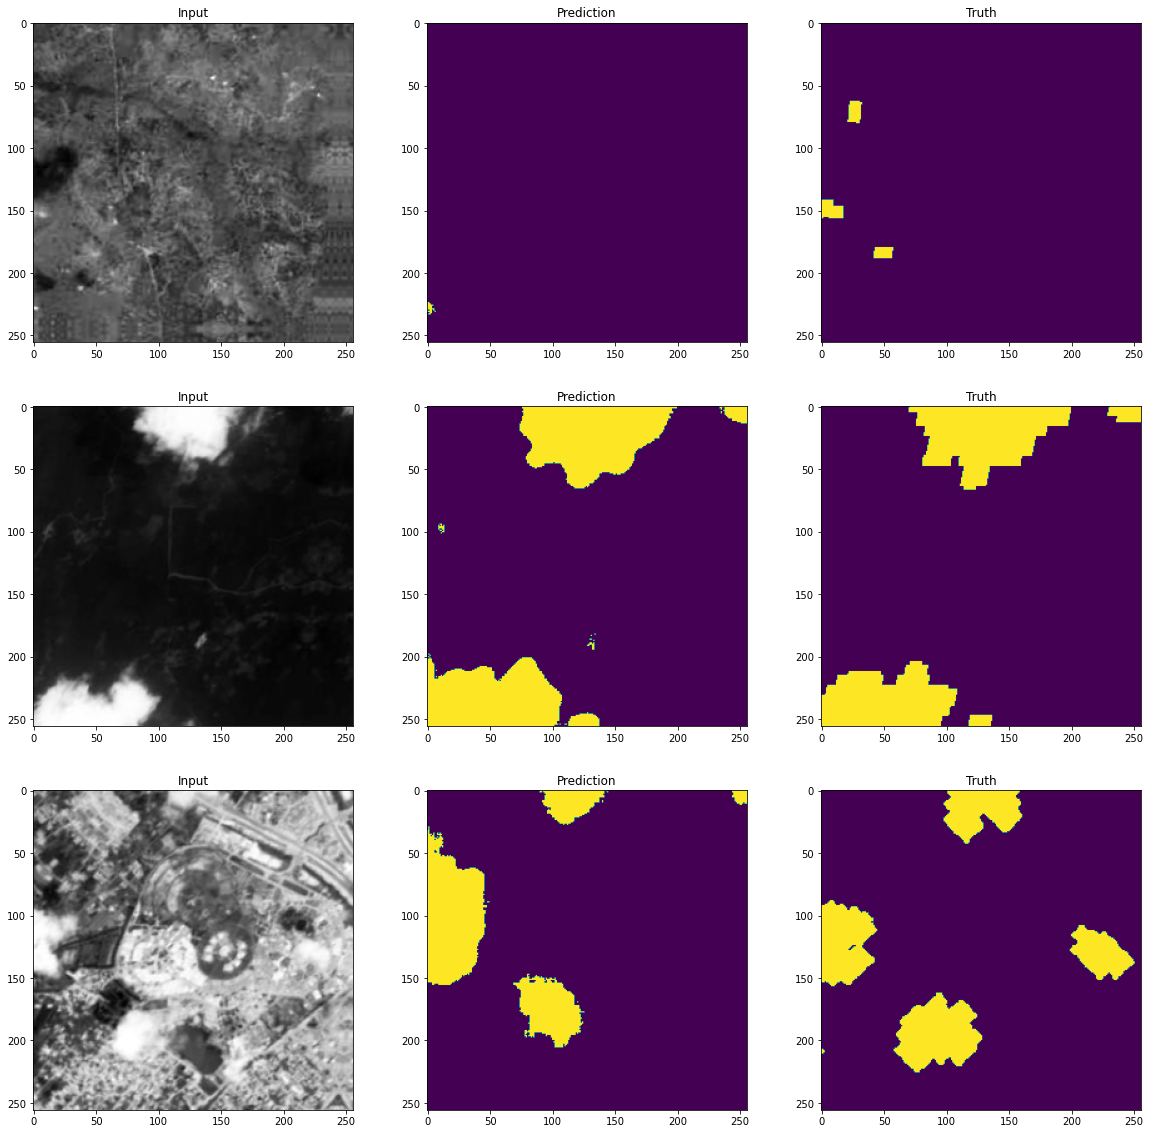

In [61]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for (ax1, ax2, ax3) in axes:
    idx = np.random.randint(len(valid_X))
    pred = model.predict(valid_X[idx][np.newaxis, :, :, np.newaxis])
    ax1.imshow(valid_X[idx], 'gray')
    ax1.set_title('Input')
    im2 = ax2.imshow(pred[0] > 0.5)
    ax2.set_title('Prediction')
    ax3.imshow(valid_y[idx])
    ax3.set_title('Truth')
plt.show()

## Training Curves

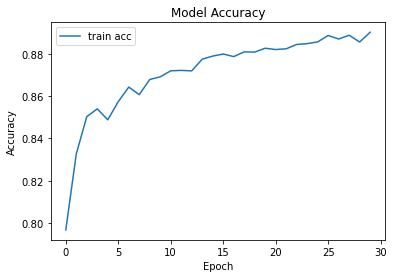

In [62]:
# plotting model accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Model Accuracy")
plt.legend(loc='best')


plt.savefig("accuracy_vs_epoch.png")
plt.show()

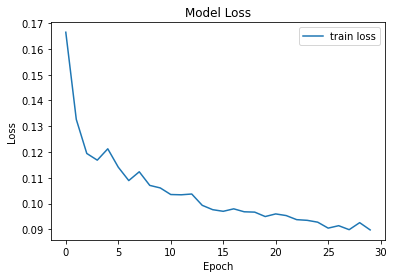

In [63]:
# plotting model loss
plt.plot(history.history['loss'], label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Model Loss")
plt.legend(loc='best')

plt.savefig("loss_vs_epoch.png")
plt.show()